In [1]:
import torch
import os
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import time as time
import nibabel as nib
import random
from tqdm import tqdm

np.random.seed(0)
random.seed(5)
torch.manual_seed(0)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
numbers = ["0001","0017","0018","0038","0040","0042","0046","0087","0090","0108","0116","0131","0178","0190",
           "0227","0248","0267","0282","0285","0398","0448","0466","0504","0514","0535","0564","0598","0606",
           "0607","0618","0620","0623","0642","0646","0655","0668","0675","0681","0719","0761","0762","0783",
           "0786","0868","0877","0887","0895","0902","0931","0979","1007","1013","1029","1033","1068","1142",
           "1143","1163","1190","1260","1275","1347","1383","1389","1416","1435","1441","1447","1451","1514",
           "1520","1602","1611","1621","1680","1684","1686","1710","1720","1739","1743","1749","1753","1760",
           "1795","1805","1845","1858","1876","1889","1892","1898","1899","1918","1924","1932","1952","1961",
           "1972","1987","2003","2007","2016","2020","2022","2030","2045","2047","2049","2053","2055","2074",
           "2077","2080","2091","2094","2103","2115","2128","2142","2144","2146","2152","2156","2158","2160",
           "2161","2179","2180","2181","2183","2186","2188","2212","2221","2231","2234","2245"]
SPLIT = 50
numbers = numbers[SPLIT + 25:]
SIM_BRAIN = '2245'
TYPE = '6'
SR = True

In [3]:
stats = np.load("stats_unet.npy") if SR else np.load("stats_no_sr.npy")

In [4]:
stats

array([[7.11421378, 4.20994112]])

### Grab 256x256 brains

In [5]:
fastt2_files, mask_files, lesion_mask_files = [], [], []
mwf_files = []

brain2245, label2245 = [], []
mask2245, lesion2245 = [], []

for number in numbers:
    file_root = "../" + number + "/"
    mask_files.append(file_root + "tightmask.nii.gz")
    lesion_mask_files.append(file_root + "lesion.nii.gz")
    if TYPE == '6':
        fastt2_files.append(file_root + "FASTT2_FULL.nii.gz")
    else:
        fastt2_files.append(file_root + "FASTT2_SNR_200_SIM.nii.gz")
    if SR:
        mwf_files.append(file_root + "MWF.nii.gz")
    else:
        mwf_files.append(file_root + "MWF_NO_SR.nii.gz")

mask_array, lesion_mask_array = [], []
brains, labels = [], []

for i in range(len(mask_files)):
    mask_array.append(nib.load(mask_files[i]).get_fdata())
    if (numbers[i] == '2245'):
        mask2245 = nib.load(mask_files[i]).get_fdata()[None]
    
for i in range(len(lesion_mask_files)):
    data = nib.load(lesion_mask_files[i]).get_fdata()
    data[data >= 1] = 1
    lesion_mask_array.append(data)
    if (numbers[i] == '2245'):
        lesion2245 = data[None]

for i in range(len(mask_files)):
    brain = nib.load(fastt2_files[i]).get_fdata().transpose((3,0,1,2))
    brains.append(brain)
    if (numbers[i] == '2245'):
        cleanBrain = nib.load("../2245/FAST_T2_NO_NOISE.nii.gz").get_fdata().transpose((3,0,1,2))
        brain2245 = np.array(cleanBrain)[None]
        
for i in range(len(mask_files)):
    mwf = nib.load(mwf_files[i]).get_fdata() * mask_array[i]
    mwf = mwf[None]
    labels.append(mwf)
    if (numbers[i] == '2245'):
        label2245 = mwf[None]
    
# BIG NUMBER: n, num_features, 256, 256, 32

labels = np.array(labels)
brains = np.array(brains)
mask_array = np.array(mask_array)
lesion_mask_array = np.array(lesion_mask_array)

In [6]:
from Hang.annPersonalBatchNorm_pytorchLightning import ann_256_256_32, ann_big

In [7]:
def calculateResultsErrorTable(state_dicts, stats, testBrains, testLabels, testMasks, numbers, lesions = None, 
                               save=False, brainType = "real", lesion = False):
    featureNumPaths = ["MWF", "IEWF", "CSFF", "MWF_T2", "IEWF_T2", "CSFF_T2"]
    for state_dict in state_dicts:
        model = ann_256_256_32(0.01, [256,256,32], 0.0012, n_classes=1, in_channels = int(TYPE)).float() if TYPE=='6' else ann_big(0.01, [256,256,32], 0.0012, n_classes=1, in_channels = int(TYPE)).float()
        state_dict = torch.load(state_dict, map_location='cpu')
        model.load_state_dict(state_dict["state_dict"])
        model = model.float().to(device)
        model.eval()
        results = {}
        results[0] = []
        
        for idx in range(len(testBrains)):
            size = testBrains.shape[2:]  # 256, 256, 32
            part = ()
            number = numbers[idx] if len(testBrains) == len(numbers) else 'average'
            signal = np.divide(testBrains[idx], testBrains[idx][0] + 1e-16)
            # signal shape: num_features, 256, 256, 32
            signal = signal.swapaxes(1,3)
            # signal shape: num_features, 32, 256, 256
            signal = signal.reshape(int(TYPE),size[2],-1).swapaxes(0,2) 
            # signal shape: -1, 32, num_features
            output = np.zeros((1,1,size[1],size[0],size[2]))  # 1, 1, 256, 256, 32
            for i in range(size[2]):  # 32
                out = model(torch.tensor(signal[:,i]).float().to(device)).to(device)
                out = out.reshape(size[1],size[0],-1).permute(2,0,1)  # -1, 256, 256
                output[0,:,:,:,i] = out.detach().cpu().numpy() 
            label = testLabels[idx].copy()
            for i in range(1):
                output[0,i] *= stats[i][1]
                output[0,i] += stats[i][0]
            
            label = np.nan_to_num(label)
            output = np.nan_to_num(output)
            mask = testMasks[idx].copy()
            output = output[0].swapaxes(1,2)
            
            for feature_num in range(1):
                if (lesion):
                    lesionMask = lesions[idx]
                    if (lesionMask.sum() == 0):
                        continue
                    brain = np.zeros(output[0].shape, dtype=float)
                    label_big = np.zeros(output[0].shape, dtype=float)
                    min_val = -3000
                    max_val = 3000
                    if (feature_num == 0):
                        min_val = 0
                        max_val = 100
                    brain = np.clip(output[feature_num] * mask, min_val, max_val)
                    brain = brain * lesionMask
                    label_big =  label[feature_num] * mask
                    label_big =  label_big * lesionMask
                    error = abs(-label_big+brain)
                    error = error[lesionMask == 1]
                    results[feature_num].append(np.mean(error))
                else:
                    brain = np.zeros(size, dtype=float) 
                    label_big = np.zeros(size, dtype=float)
                    min_val = -3000
                    max_val = 3000
                    if (feature_num == 0):
                        min_val = 0
                        max_val = 100
                    brain = np.clip(output[feature_num] * mask, min_val, max_val)
                    label_big =  label[feature_num] * mask
                    error = abs(-label_big+brain)
                    error = error[mask == 1]
                    results[feature_num].append(np.mean(error))
                    if (save):
                        brain = np.clip(brain, -3000, 3000)
                        label_big = np.clip(label_big, -3000, 3000)
                        brainT = np.zeros(size)
                        labelT = np.zeros(size)
                        brainT[part] = brain
                        labelT[part] = label_big
                        label_big = labelT
                        brain = brainT
                        folder = "ann_256_256_32" if TYPE == '6' else "ann_32_te"
                        folder = "ann_256_256_32_no_sr" if SR == False else folder
                        base = f"results/{folder}/{featureNumPaths[feature_num]}/"
                        sample = f"../{number}/MWF.nii.gz" if number != "average" else ""
                        save_nii(brain, base+f"{number}_pred_MLP_{brainType}.nii.gz", sample)
                        save_nii(label_big, base+f"{number}_label_MLP_{brainType}.nii.gz", sample)
                        save_nii(brain-label_big, base+f"{number}_err_MLP_{brainType}.nii.gz", sample)
    return results

### Simulation

In [9]:
def generateBrains(cleanBrain, labels, masks, noise):
    brains = cleanBrain.copy()
    brains += noise
    for i in range(6):
        brains[:,i] *= masks
    return brains

### Reproducibility

In [49]:
reproMaskFiles = []
reproFiles = []
reproMWFFiles = []

reproNumbers = ['125545', '093924', '151026', '111721', '093923', '151025', '113308', '113307', '171732', '101851', 
                '125546', '163835', '163834', '154655', '101850', '175630', '175631', '184052', '111720', '184051']
for number in reproNumbers:
    file_root = "../" + number + "/"
    reproMaskFiles.append(file_root + "tightmask.nii.gz")
    reproFiles.append(file_root + "FASTT2_FULL.nii.gz")
    reproMWFFiles.append(file_root + "MWF.nii.gz")

reproMasks = []
reproBrains = []
reproMWFs = []
for mask in reproMaskFiles:
    mask = nib.load(mask).get_fdata()
    reproMasks.append(mask)

for file_idx in range(len(reproFiles)):
    file = reproFiles[file_idx]
    brain = nib.load(file).get_fdata().transpose((3,0,1,2)) * reproMasks[file_idx]
    reproBrains.append(brain)
    
for img in reproMWFFiles:
    img = nib.load(img).get_fdata()
    reproMWFs.append(img[None])

reproMasks = np.array(reproMasks)
reproBrains = np.array(reproBrains)
reproMWFs = np.array(reproMWFs)

### Testing

### Save 256x256 test brains

In [11]:
state_dicts = []
if SR:
    if TYPE == '6':
        state_dicts = ["../mlp_models/mlp_6_echo_sr_epoch_63.ckpt"]
    else:
        state_dicts = ["../mlp_models/mlp_32_echo_sr_epoch_50.ckpt"]
else:
    state_dicts = ["../mlp_models/mlp_6_echo_no_sr_epoch_15.ckpt"]

In [12]:
state_dicts

['../mlp_models/mlp_6_echo_sr_epoch_63.ckpt']

In [12]:
res256 = calculateResultsErrorTable(state_dicts, stats, brains, labels, mask_array, numbers, save=True, 
                                    brainType='256real')

In [13]:
print(np.mean(res256[0]), np.std(res256[0])) #MAE for 256, 256, 32

2.2533090196077223 0.13585048740776992


In [14]:
res256Lesion = calculateResultsErrorTable(state_dicts, stats, brains, labels, mask_array, numbers, lesion_mask_array,
                                          lesion = True)

In [15]:
print(np.mean(res256Lesion[0]), np.std(res256Lesion[0])) #MAE L2 for 256,32

1.9661233987899742 0.2309973580845905


### Save 256x256 simulation

#### Simulate brain 1260 in 256x256 space

In [42]:
res256snr200 = []
res256snr200Lesion = []
res256snr100 = []
res256snr100Lesion = []
res256snr50 = []
res256snr50Lesion = []
res256snr25 = []
res256snr25Lesion = []

minSum200 = 10000
minSum100 = 10000
minSum50 = 10000
minSum25 = 10000

for i in tqdm(range(500)):
    '''Generating Brain'''
    NUM_BRAINS = len(brain2245)
    SNR = 200
    roi = load_nii("roi.nii.gz")
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr200 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 100
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr100 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 50
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr50 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 25
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr25 = generateBrains(brain2245, label2245, mask2245, noise)
    
    '''Testing Brain'''
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr200')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, 
                                               [SIM_BRAIN], lesion2245, save=False, lesion=True)
    res256snr200.append(tempRes)
    res256snr200Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum200):
        minSum200 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr200')

    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr100')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, 
                                               [SIM_BRAIN], lesion2245, save=False, lesion=True)
    res256snr100.append(tempRes)
    res256snr100Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum100):
        minSum100 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr100')
        
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr50')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, 
                                         [SIM_BRAIN], lesion2245,  save=False, lesion=True)
    res256snr50.append(tempRes)
    res256snr50Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum50):
        minSum50 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr50')
        
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr25')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, 
                                         [SIM_BRAIN], lesion2245,  save=False, lesion=True)
    res256snr25.append(tempRes)
    res256snr25Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum25):
        minSum25 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr25')

100%|██████████| 500/500 [32:01<00:00,  3.84s/it]


In [44]:
res256snr200Avg = compressResults(res256snr200)
res256snr100Avg = compressResults(res256snr100)
res256snr50Avg = compressResults(res256snr50)
res256snr25Avg = compressResults(res256snr25)

res256snr200LesionAvg = compressResults(res256snr200Lesion)
res256snr100LesionAvg = compressResults(res256snr100Lesion)
res256snr50LesionAvg = compressResults(res256snr50Lesion)
res256snr25LesionAvg = compressResults(res256snr25Lesion)

In [45]:
simData = [res256snr200, res256snr100, res256snr50, res256snr25]
simDataLesion = [res256snr200Lesion, res256snr100Lesion, res256snr50Lesion, res256snr25Lesion]

### Simulating on different Echo Times

In [8]:
maskNewTE = nib.load("../2245/tightmask.nii.gz").get_fdata()[None]
labelNewTE = nib.load("../2245/MWF.nii.gz").get_fdata()[None][None]

In [9]:
brainsNewTE = nib.load("../2245/FASTT2_SNR_200_SIM_NEW_TE.nii.gz").get_fdata().transpose((3,0,1,2)) * mask_array[0]
brainsNewTE = brainsNewTE[None]

In [13]:
resSim = calculateResultsErrorTable(state_dicts, stats, brainsNewTE, labelNewTE , maskNewTE, ["2245"], 
                                      save=True, brainType='new_te')

In [14]:
resSim

{0: [19.11825673649393]}

In [19]:
import matplotlib.pyplot as plt

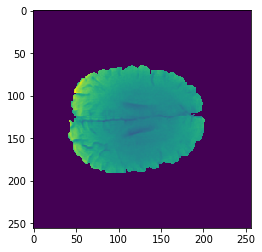

In [20]:
plt.imshow(brainsNewTE[0,0,:,:,20])

### Save Repro

In [53]:
resRepro = calculateResultsErrorTable(state_dicts, stats, reproBrains, reproMWFs, reproMasks, reproNumbers, 
                                      save=True, brainType='repro')

### Save Results

In [16]:
if SR:
    if TYPE == '6':
        np.save("mlpData.npy", [res256, res256Lesion, 
                                res256snr200Avg, res256snr100Avg, res256snr50Avg, res256snr25Avg,
                                res256snr200LesionAvg, res256snr100LesionAvg, res256snr50LesionAvg, res256snr25LesionAvg,
                                resRepro, simData, simDataLesion], allow_pickle=True)
    else:
        np.save("mlpData_32_te.npy", [res256, res256Lesion], allow_pickle=True)
else:
    np.save("mlpData_no_sr.npy", [res256, res256Lesion], allow_pickle=True)

### Some data moving

In [103]:
numbers_old = ['0001','0017','0018','0038','0040','0042','0046','0048','0076','0084','0087','0090','0099',
           '0108','0116','0131','0139','0178','0190','0227','0248','0267','0282','0285','0286','0398',
           '0423','0430','0442','0448','0460','0466','0504','0514','0535','0564','0598','0606','0607',
           '0618','0620','0623','0642','0646','0655','0662','0668','0675','0681','0719','0761','0762',
           '0783','0786','0791','0794','0857','0868','0877','0887','0893','0895','0896','0902','0921',
           '0931','0979','0995','1007','1013','1029','1033','1046','1068','1142','1143','1163','1172',
           '1190','1205','1213','1260','1266','1275','1291','1347','1351','1383','1387','1389','1416',
           '1434','1435','1441','1447','1451','1502','1514','1520','1531','1602','1611','1621','1644',
           '1680','1684','1686','1710','1720','1735','1739','1743','1749','1753','1757','1760','1795',
           '1805','1845','1858','1876','1889','1892','1894','1898','1899','1918','1923','1924','1932',
           '1952','1961','1972','1987','1989','2001','2003','2007','2016','2020','2022','2030','2034',
           '2045','2047','2049','2053','2055','2074','2077','2080','2081','2091','2094','2100','2103',
           '2115','2128','2142','2144','2146','2152','2156','2158','2160','2161','2164','2179','2180',
           '2181','2183','2186','2188','2212','2221','2231','2234','2245']

In [86]:
files = os.listdir("../MS138")
numbers = []
for file in files:
    number = file.split("_")[0]
    if (number not in numbers):
        try:
            num = int(number)
            numbers.append(number)
        except:
            print(number)

In [42]:
numbers.sort()

In [29]:
files = os.listdir("../MS138")
numbers = []
for file in files:
    number = file.split("_")[0]
    if (number == "2094"):
        print(file)

2094_20190214_101028_MWF.nii.gz
2094_20190214_101028_MWF_t2.nii.gz
2094_20190214_101028_T2FLAIR_to_FASTT2.nii.gz
2094_20190214_101028_T1FS_ribbon_label_to_FASTT2_brain_mask.nii.gz
2094_20190214_101028_MWF_t3.nii.gz
2094_20190214_101028_MWF_w1.nii.gz
2094_20190214_101028_MWF_w3.nii.gz
2094_20190214_101028_MWF_t1.nii.gz
2094_20190214_101028_T2FLAIR_lesion_label_to_FASTT2.nii.gz
2094_20190214_101028_FASTT2_brain_mask.nii.gz
2094_20190214_101028_FASTT2_FULL.nii.gz
2094_20190214_101028_MWF_w2.nii.gz


In [47]:
from shutil import copyfile

In [48]:
files = os.listdir("../MS138")
for file in files:
    if ("T1FS_ribbon_label_to_FASTT2_brain_mask" in file):
        number = file.split("_")[0]
        copyfile(f"../MS138/{file}", f"../{number}/cropped_mask.nii.gz")
    elif ("MWF.nii.gz" in file):
        number = file.split("_")[0]
        copyfile(f"../MS138/{file}", f"../{number}/MWF.nii.gz")

In [64]:
f"../{direct}/{file}"

'../175630/brain_mask.nii.gz'

In [97]:
good_files = ['segmentation.nii.gz', 'MWF.nii.gz', 'FASTT2_FULL.nii.gz', 'brain_mask.nii.gz', 
              'lesion.nii.gz', 't2.nii.gz', 't1.nii.gz', 'w1.nii.gz', 't3.nii.gz', 'w3.nii.gz', 
              'w2.nii.gz', 'mwf.nii', 'cropped_mask.nii.gz',]
dirs = os.listdir("..")
to_remove = []
for direct in dirs:
    try:
        int(direct)
        files = os.listdir(f"../{direct}")
        for file in files:
            if (file not in good_files):
                to_remove.append(f"../{direct}/{file}")
    except:
        pass

In [100]:
for file in to_remove:
    if (os.path.isdir(file)):
        continue
    os.remove(file)